In [2]:
import glob
import os
import random
from collections import Counter

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import pandas as pd
import torch
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm

# Preprocessing

## Stats

In [ ]:
def calculate_dataset_stats(dataset_dir):
    sum_r = sum_g = sum_b = 0.0
    sum_sq_r = sum_sq_g = sum_sq_b = 0.0
    total_pixels = 0
    processed_files = 0
    problematic_files = []

    total_images = 0
    for class_dir in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_dir)
        if os.path.isdir(class_path):
            total_images += len([f for f in os.listdir(class_path) 
                               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    with tqdm(total=total_images, desc="Processing Images", 
             unit="img", dynamic_ncols=True) as pbar:
        
        for class_dir in os.listdir(dataset_dir):
            class_path = os.path.join(dataset_dir, class_dir)
            if not os.path.isdir(class_path):
                continue

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    problematic_files.append(f"{img_path} - Not an image")
                    pbar.update(1)
                    continue
                
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        raise ValueError("OpenCV failed to read image")
                        
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    if img.dtype != np.uint8:
                        raise ValueError(f"Unexpected dtype: {img.dtype}")
                        
                    img = img.astype(np.float32) / 255.0
                    
                    sum_r += np.sum(img[:, :, 0])
                    sum_g += np.sum(img[:, :, 1])
                    sum_b += np.sum(img[:, :, 2])
                    
                    sum_sq_r += np.sum(np.square(img[:, :, 0]))
                    sum_sq_g += np.sum(np.square(img[:, :, 1]))
                    sum_sq_b += np.sum(np.square(img[:, :, 2]))
                    
                    total_pixels += img.shape[0] * img.shape[1]
                    processed_files += 1

                except Exception as e:
                    problematic_files.append(f"{img_path} - {str(e)}")
                
                finally:
                    pbar.update(1)
                    pbar.set_postfix({
                        'Processed': processed_files,
                        'Errors': len(problematic_files),
                        'Current': os.path.basename(class_dir)
                    })

    if total_pixels == 0:
        raise ValueError("No valid images processed - check dataset path or file formats")

    mean = [
        round(sum_r / total_pixels, 5),
        round(sum_g / total_pixels, 5),
        round(sum_b / total_pixels, 5)
    ]
    
    std = [
        round(np.sqrt((sum_sq_r / total_pixels) - (mean[0] ** 2)), 5),
        round(np.sqrt((sum_sq_g / total_pixels) - (mean[1] ** 2)), 5),
        round(np.sqrt((sum_sq_b / total_pixels) - (mean[2] ** 2)), 5)
    ]

    print("\nValidation Summary:")
    print(f"Total images attempted: {total_images}")
    print(f"Successfully processed: {processed_files}")
    print(f"Problematic files: {len(problematic_files)}")
    
    if problematic_files:
        print("\nFirst 5 errors:")
        for error in problematic_files[:5]:
            print(f" - {error}")

    return mean, std

In [ ]:
root_dir_dataset = r'Dataset/All'
mean, std = calculate_dataset_stats(root_dir_dataset)

dataset_mean = [round(float(m), 5) for m in mean]
dataset_std = [round(float(s), 5) for s in std]

print("\nDataset Statistics:")
print("Dataset Mean (RGB):", dataset_mean)
print("Dataset Std (RGB):", dataset_std)

assert all(0 <= m <= 1 for m in dataset_mean), "Mean values out of [0,1] range"
assert all(0 <= s <= 1 for s in dataset_std), "Std values out of [0,1] range"

if (abs(mean[0]*255 - 0.485 * 255) < 0.01):
    print("Red mean mismatch")
if (abs(mean[1]*255 - 0.456 * 255) < 0.01):
    print("Green mean mismatch")
if (abs(mean[2]*255 - 0.406 * 255) < 0.01):
    print("Blue mean mismatch")

if (abs(std[0]*255 - 0.229 * 255) < 0.01):
    print("Red std mismatch")
if (abs(std[1]*255 - 0.224 * 255) < 0.01):
    print("Green std mismatch")
if (abs(std[2]*255 - 0.225 * 255) < 0.01):
    print("Blue std mismatch")

print("\nBasic validation checks passed!")

In [ ]:
def get_image_analysis(image_path):
    analysis = {}
    
    analysis['path'] = image_path
    analysis['filesize'] = os.path.getsize(image_path)
    analysis['modified_time'] = os.path.getmtime(image_path)
    
    try:
        with Image.open(image_path) as img:
            analysis['format'] = img.format
            analysis['mode'] = img.mode
            analysis['size'] = img.size
            analysis['info'] = img.info
            
        img_cv = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if img_cv is not None:
            analysis['dtype'] = img_cv.dtype
            analysis['shape'] = img_cv.shape
            analysis['channels'] = img_cv.shape[2] if len(img_cv.shape) > 2 else 1
            
            analysis['stats'] = {
                'min': img_cv.min(),
                'max': img_cv.max(),
                'mean': img_cv.mean(),
                'std': img_cv.std(),
                'unique': len(np.unique(img_cv))
            }
            
            import hashlib
            analysis['md5'] = hashlib.md5(img_cv.tobytes()).hexdigest()
            
            analysis['has_alpha'] = (img_cv.shape[2] == 4) if len(img_cv.shape) > 2 else False
            
        return analysis
    except Exception as e:
        analysis['error'] = str(e)
        return analysis

def visualize_image(analysis):
    img = cv2.imread(analysis['path'])
    if img is None:
        return

    display_text = [
        f"Size: {analysis['size'][0]}x{analysis['size'][1]}",
        f"Channels: {analysis['channels']}",
        f"Mode: {analysis['mode']}",
        f"Type: {analysis['dtype']}",
        f"Range: {analysis['stats']['min']}-{analysis['stats']['max']}",
        f"Mean: {analysis['stats']['mean']:.1f} ± {analysis['stats']['std']:.1f}"
    ]

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    plt.text(0.5, -0.1, '\n'.join(display_text),
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.axis('off')
    plt.show()

def analyze_dataset(dataset_root, sample_per_folder=1, save_report=False):
    report = []
    
    for root, dirs, files in os.walk(dataset_root):
        if not files:
            continue
            
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        samples = image_files[:sample_per_folder]
        
        for img_file in samples:
            img_path = os.path.join(root, img_file)
            analysis = get_image_analysis(img_path)
            report.append(analysis)
            

            print(f"\nClass: {os.path.basename(root)}")
            print(f"Image: {img_file}")
            print("-"*40)
            for k, v in analysis.items():
                if k == 'exif': continue
                if k == 'info': continue
                print(f"{k:>15}: {v}")
                
            if 'error' not in analysis:
                visualize_image(analysis)
            else:
                print(f"Error processing image: {analysis['error']}")
    
    if save_report:
        with open('dataset_analysis_report.txt', 'w') as f:
            for entry in report:
                f.write(f"{'-'*40}\n")
                for k, v in entry.items():
                    f.write(f"{k:>15}: {v}\n")
    
    return report


dataset_path = r"Dataset/All"
analyze_dataset(dataset_path, sample_per_folder=1)

## Data Visulization

In [10]:
root_dir = r'Dataset'
root_dir_train = r'Dataset/Train'
root_dir_test = r'Dataset/Test'
root_dir_val = r'Dataset/Val'

C:\Users\tahaa\AppData\Local\Temp\ipykernel_20752\2973037813.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [plt.cm.get_cmap('viridis')(i / n_classes) for i in range(n_classes)]


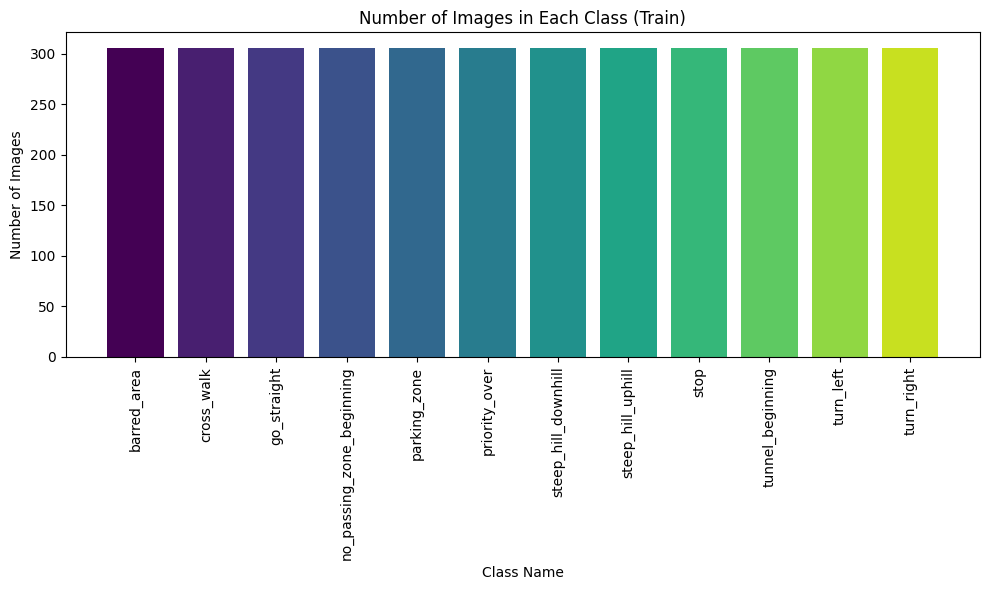

In [15]:
class_folders = os.listdir(root_dir_train)

image_counts = {}

for class_folder in class_folders:
    path = os.path.join(root_dir_train, class_folder)
    if os.path.isdir(path):
        image_count = len(os.listdir(path))
        image_counts[class_folder] = image_count

# Convert dictionary keys to list for matplotlib
class_names = list(image_counts.keys())
count_values = list(image_counts.values())

n_classes = len(class_names)
colors = [plt.cm.get_cmap('viridis')(i / n_classes) for i in range(n_classes)]

plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, count_values, color=colors)
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class (Train)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Data Augmentation

In [16]:
root_dir_train = r'Dataset/train'
root_dir_augmented = r'Dataset/Augmented'
os.makedirs(root_dir_augmented, exist_ok=True)

In [ ]:


# Define your Albumentations transform (similar to ImageDataGenerator settings)
# Note: For saving images, we do not apply normalization so that pixel values remain in [0,255].
augment_transform = A.Compose([
    A.Resize(128, 128),
    A.Rotate(limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=0, p=0.5),
    A.Affine(shear=15, p=0.5),
    A.Zoom(scale_limit=0.15, p=0.5),
    # You may add more transformations if desired.
    # ToTensorV2() is omitted here since we want to save as images.
])

# Loop through each class folder in train_path
class_folders = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])
image_counts = {}

for class_folder in class_folders:
    class_dir = os.path.join(train_path, class_folder)
    
    # Count number of images in this class
    images = sorted(glob.glob(os.path.join(class_dir, "*.png")))
    image_counts[class_folder] = len(images)
    
    # Create corresponding output folder (preserve class structure)
    output_class_dir = os.path.join(output_aug_dir, class_folder)
    os.makedirs(output_class_dir, exist_ok=True)
    
    # Process each image; create one augmented version per image, for example.
    for img_name in images:
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping unreadable file: {img_path}")
            continue
        # Apply augmentation transform
        augmented = augment_transform(image=img)
        aug_img = augmented["image"]
        # Save augmented image. You may name it based on original filename.
        save_name = "aug_" + img_name
        save_path = os.path.join(output_class_dir, save_name)
        cv2.imwrite(save_path, aug_img)

In [ ]:
dataset_mean = [0.48948, 0.48214, 0.53307]
dataset_std = [0.21354, 0.2212, 0.20459]

img_size = 32

In [ ]:
transform_album = A.Compose([
        A.Resize(128, 128),
        A.Affine(
            scale=(0.95, 1.05),
            shear=(-5, 5),
            fill=0,
            p=0.7),
        A.Perspective(
            scale=(0.05, 0.1),
            keep_size=True,
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_CONSTANT,
            fill=0,
            p=0.5),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.5, 0.5),
            contrast_limit=(-0.2, 0.2),
            p=0.8),
        A.RGBShift(
            r_shift_limit=(-10, 10),
            g_shift_limit=(-10, 10),
            b_shift_limit=(-10, 10),
            p=0.8),
        A.MotionBlur(
            blur_limit=(5, 7),
            p=0.3),
        A.GaussNoise(
            std_range=(0.01, 0.02),
            p=0.3),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std),
            max_pixel_value=255.0,
            normalization="standard",
            p=1.0),
        ToTensorV2(p=1.0)
    ])

In [ ]:
transform_simple = A.Compose([
        A.Resize(32, 32),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std),
            max_pixel_value=255.0,
            normalization="standard",
            p=1.0),
        ToTensorV2(p=1.0)
    ])

In [ ]:
transform_resize = A.Compose([
        A.Resize(32, 32),
        ToTensorV2(p=1.0)
    ])

In [ ]:
root_dir_train = r'Dataset/Train'
root_dir_augmented = r'Dataset/Augmented'
os.makedirs(root_dir_augmented, exist_ok=True)

images_path_list = []
labels_path_list = []
class_idx = {}
augmentation_count = 5

class_names = sorted([d for d in os.listdir(root_dir_train)
                      if os.path.isdir(os.path.join(root_dir_train, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    images_tmp = os.path.join(root_dir_train, class_name, "*.png")
    images_paths = glob.glob(images_tmp)
    
    for img_path in images_paths:
        images_path_list.append(img_path)
        labels_path_list.append(cls_idx)

### Train Augmentation

In [ ]:
pbar = tqdm(total=len(images_path_list) * augmentation_count, 
            desc="Augmenting Images", 
            unit="img", 
            dynamic_ncols=True)

for class_name in class_names:
    class_dir = os.path.join(root_dir_augmented, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    if not os.path.exists(class_dir):
        raise RuntimeError(f"Failed to create directory: {class_dir}")

for img_path in images_path_list:
    class_name = os.path.basename(os.path.dirname(img_path))
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {img_path}")
        pbar.update(augmentation_count)
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    for aug_num in range(1, augmentation_count + 1):
        transformed = transform_album(image=img)
        transformed_img = transformed['image']
        
        transformed_img = transformed_img.permute(1, 2, 0).numpy()
        transformed_img = (transformed_img * np.array(dataset_std) + np.array(dataset_mean))
        transformed_img = np.clip(transformed_img * 255, 0, 255).astype(np.uint8)
        
        new_filename = f"{base_name}_{aug_num:02d}.png"
        new_path = os.path.join(root_dir_augmented, class_name, new_filename)
        
        if not os.path.exists(os.path.dirname(new_path)):
            os.makedirs(os.path.dirname(new_path), exist_ok=True)
        
        try:
            save_success = cv2.imwrite(new_path, cv2.cvtColor(transformed_img, cv2.COLOR_RGB2BGR))
            if not save_success:
                Image.fromarray(transformed_img).save(new_path)
                print(f"Used PIL fallback for {new_path}")
        except Exception as save_error:
            print(f"Failed to save {new_path}: {str(save_error)}")
            continue
        
        pbar.update(1)
        pbar.set_postfix_str(f"Processing: {class_name}/{new_filename}")

pbar.close()
output_files = glob.glob(os.path.join(root_dir_augmented, "**", "*.png"), recursive=True)
print(f"\nAugmentation complete. {len(images_path_list)} → {len(images_path_list)*augmentation_count} files")
print(f"Augmented images saved in: {os.path.abspath(root_dir_augmented)}")

### Normalized Test

In [ ]:
root_dir_test = r'Dataset/Test'

images_path_list = []
for class_name in os.listdir(root_dir_test):
    class_path = os.path.join(root_dir_test, class_name)
    if os.path.isdir(class_path):
        images_path_list.extend(glob.glob(os.path.join(class_path, "*.png")))

pbar = tqdm(total=len(images_path_list), 
           desc="Processing Images", 
           unit="img", 
           dynamic_ncols=True)

for img_path in images_path_list:
    try:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        transformed = transform_simple(image=img)
        processed_img = transformed['image']
        
        processed_img = processed_img.permute(1, 2, 0).numpy()
        processed_img = (processed_img * dataset_std + dataset_mean) * 255
        processed_img = processed_img.clip(0, 255).astype(np.uint8)
        
        cv2.imwrite(img_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        pbar.update(1)
        
    except Exception as e:
        print(f"\nError processing {img_path}: {str(e)}")
        continue

pbar.close()
print(f"\nProcessing complete. {len(images_path_list)} images replaced")
print(f"Original images overwritten in: {os.path.abspath(root_dir_test)}")

### Normalized Val

In [ ]:
root_dir_val = r'Dataset/Val'

images_path_list = []
for class_name in os.listdir(root_dir_val):
    class_path = os.path.join(root_dir_val, class_name)
    if os.path.isdir(class_path):
        images_path_list.extend(glob.glob(os.path.join(class_path, "*.png")))

pbar = tqdm(total=len(images_path_list), 
           desc="Processing Images", 
           unit="img", 
           dynamic_ncols=True)

for img_path in images_path_list:
    try:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        transformed = transform_simple(image=img)
        processed_img = transformed['image']
        
        processed_img = processed_img.permute(1, 2, 0).numpy()
        processed_img = (processed_img * dataset_std + dataset_mean) * 255
        processed_img = processed_img.clip(0, 255).astype(np.uint8)
        
        cv2.imwrite(img_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        pbar.update(1)
        
    except Exception as e:
        print(f"\nError processing {img_path}: {str(e)}")
        continue

pbar.close()
print(f"\nProcessing complete. {len(images_path_list)} images replaced")
print(f"Original images overwritten in: {os.path.abspath(root_dir_val)}")

## Dataset Class

In [ ]:
class TrafficSignDB(Dataset):
    def __init__(self, images_path_list, labels_path_list, transform=None):
        self.images_path_list = images_path_list
        self.labels_path_list = labels_path_list
        self.transform = transform
        self.class_names = sorted(list(set(os.path.basename(os.path.dirname(p)) for p in images_path_list)))
        self.idx_to_class = self._create_label_mapping()
        
    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}
    
    def __len__(self):
        return len(self.images_path_list)
    
    def __getitem__(self, index):
        path = self.images_path_list[index]
        label = self.labels_path_list[index]
        
        try:
            import cv2
            image = cv2.imread(path)
            if image is None:
                raise ValueError("Image could not be read")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                if isinstance(self.transform, A.Compose):
                    # Albumentations Pipeline
                    augmented = self.transform(image=image)
                    image = augmented["image"]
                else:
                    # PyTorch PIL
                    from PIL import Image
                    image = Image.open(path).convert("RGB")
                    image = self.transform(image)
            else:
                from albumentations.pytorch import ToTensorV2
                image = ToTensorV2()(image=image)["image"]
            
        except Exception as e:
            print(f"Error processing image {path}: {e}")
            image = torch.zeros(3, 32, 32)
            
        return image, label
    
    def get_class_name(self, label_idx):
        return self.idx_to_class.get(label_idx, "unknown")

In [ ]:
class TrafficSignDBNPY(Dataset):
    def __init__(self, X_npy_path, y_npy_path, transform=None):
        if isinstance(X_npy_path, (str, bytes, os.PathLike)):
            self.X = np.load(X_npy_path)
        else:
            self.X = X_npy_path

        if isinstance(y_npy_path, (str, bytes, os.PathLike)):
            self.y = np.load(y_npy_path)
        else:
            self.y = y_npy_path
            
        self.transform = transform
        self.y_int = np.argmax(self.y, axis=1)
        
        self.class_names = [
            'barred_area',
            'cross_walk',
            'go_straight',
            'no_passing_zone_beginning',
            'parking_zone',
            'priority_over',
            'steep_hill_downhill',
            'steep_hill_uphill',
            'stop',
            'tunnel_beginning',
            'turn_left',
            'turn_right'
        ]
        self.idx_to_class = self._create_label_mapping()

    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        path = self.X[index]
        label = int(self.y_int[index])
        
        if self.transform:
            image = path.transpose(1, 2, 0)
            transformed = self.transform(image=image)
            image = transformed["image"]
        else:
            image = torch.from_numpy(path)
        
        return image, label
    
    def get_class_name(self, label_idx):
        return self.class_names[label_idx] if label_idx < len(self.class_names) else "unknown"

## Train/Test List and NPY

In [ ]:
img_size = 32

root_dir = r'Dataset'
root_dir_train = r'Dataset/Train'
root_dir_test = r'Dataset/Test'
root_dir_val = r'Dataset/Val'

images_path_list_train = []
labels_path_list_train = []

images_path_list_test = []
labels_path_list_test = []

images_path_list_val = []
labels_path_list_val = []

class_idx = {}

class_names = sorted([d for d in os.listdir(root_dir_train)
                      if os.path.isdir(os.path.join(root_dir_train, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    
    # Train images (Augmented)
    train_pattern = os.path.join(root_dir_train, class_name, "*.png")
    train_images_paths = glob.glob(train_pattern)
    np.random.shuffle(train_images_paths)
    for train_path in train_images_paths:
        images_path_list_train.append(train_path)
        labels_path_list_train.append(cls_idx)

    # Test images
    test_pattern = os.path.join(root_dir_test, class_name, "*.png")
    test_images_paths = glob.glob(test_pattern)
    np.random.shuffle(test_images_paths)
    for test_path in test_images_paths:
        images_path_list_test.append(test_path)
        labels_path_list_test.append(cls_idx)
    
    # Validation images
    val_pattern = os.path.join(root_dir_val, class_name, "*.png")
    val_images_paths = glob.glob(val_pattern)
    np.random.shuffle(val_images_paths)
    for val_path in val_images_paths:
        images_path_list_val.append(val_path)
        labels_path_list_val.append(cls_idx)

In [ ]:
total_train = len(images_path_list_train)
total_test = len(images_path_list_test)
total_val = len(images_path_list_val)
total_all = total_train + total_test

perc_train = total_train / total_all * 100
perc_test = total_test / total_all * 100

print("Final dataset sizes:")
print(f"Training: {total_train} samples ({perc_train:.2f}%)")
print(f"Testing: {total_test} samples ({perc_test:.2f}%)")
print(f"Validation: {total_val} samples")

train_counts = Counter(labels_path_list_train)
test_counts = Counter(labels_path_list_test)
val_counts = Counter(labels_path_list_val)

print("\nTraining Class Distribution:")
for idx in sorted(train_counts.keys()):
    print(f"Class '{class_idx[idx]}' (Index {idx}): {train_counts[idx]} samples")

print("\nTesting Class Distribution:")
for idx in sorted(test_counts.keys()):
    print(f"Class '{class_idx[idx]}' (Index {idx}): {test_counts[idx]} samples")

print("\nValidation Class Distribution:")
for idx in sorted(val_counts.keys()):
    print(f"Class '{class_idx[idx]}' (Index {idx}): {val_counts[idx]} samples")

In [ ]:
if ('images_path_list_train' in globals() and 
    'images_path_list_test' in globals() and 
    'images_path_list_val' in globals()):
    
    train_files = set(images_path_list_train)
    test_files = set(images_path_list_test)
    val_files = set(images_path_list_val)
    
    dup_train_val = train_files.intersection(val_files)
    dup_train_test = train_files.intersection(test_files)
    dup_val_test = val_files.intersection(test_files)
    
    print("Duplicates between training and validation:", len(dup_train_val))
    print("Duplicates between training and test:", len(dup_train_test))
    print("Duplicates between validation and test:", len(dup_val_test))
else:
    print("File path lists not found; skipping duplicate check.")

In [ ]:
def one_hot_encoder(labels, num_classes):
    encoded = np.zeros((len(labels), num_classes), dtype=np.float32)
    encoded[np.arange(len(labels)), labels] = 1.0
    return encoded

In [ ]:
def process_img_npy(image_paths, labels, save_dir, dataset_type, mean, std):
    os.makedirs(save_dir, exist_ok=True)
    X = []
    y = []
    
    mean_arr = np.array(mean, dtype=np.float32)
    std_arr = np.array(std, dtype=np.float32)
    
    for img_path, label in tqdm(zip(image_paths, labels), 
                              total=len(image_paths), 
                              desc=f"Processing {save_dir}"):
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Skipping unreadable file: {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            
            img = img.astype(np.float32) / 255.0
            img = (img - mean_arr) / std_arr
            
            img = np.transpose(img, (2, 0, 1))
            
            X.append(img)
            y.append(label)
        except Exception as e:
            print(f"Skipping corrupted file {img_path}: {e}")
    
    X = np.array(X, dtype=np.float32)
    y = one_hot_encoder(np.array(y, dtype=np.int64), num_classes=len(class_names))
    
    np.save(os.path.join(save_dir, f'X_{dataset_type}_data.npy'), X)
    np.save(os.path.join(save_dir, f'y_{dataset_type}_labels.npy'), y)
    print(f"X shape: {X.shape}, y shape: {y.shape}") 
    print(f"\nSaved {X.shape[0]} samples to {save_dir}\n")

In [ ]:
process_img_npy(images_path_list_train,
                labels_path_list_train, 
               root_dir,
               'train',
               mean=dataset_mean,
               std=dataset_std)

process_img_npy(images_path_list_test,
                labels_path_list_test,
               root_dir,
               'test',
               mean=dataset_mean,
               std=dataset_std)

process_img_npy(images_path_list_val,
                labels_path_list_val,
               root_dir,
               'val',
               mean=dataset_mean,
               std=dataset_std)

print("\nDataset preprocessing complete!")
print(f"Final dataset sizes:")
print(f"- Training: {len(images_path_list_train)} samples")
print(f"- Testing: {len(images_path_list_test)} samples")
print(f"- Validation: {len(images_path_list_val)} samples")
print(f"One-hot encoded labels shape: ({len(class_names)} classes)")

# EDA

In [ ]:
def load_npy_data(save_dir, type):
    X = np.load(os.path.join(save_dir, f'X_{type}_data.npy'))
    y = np.load(os.path.join(save_dir, f'y_{type}_labels.npy'))
    return X, y

X_train_npy, y_train_npy = load_npy_data(root_dir, 'train')
X_test_npy, y_test_npy = load_npy_data(root_dir, 'test')
X_val_npy, y_val_npy = load_npy_data(root_dir, 'val')

print("\nVerifying NPY file contents:")
print(f"\nTraining data shape: {X_train_npy.shape}")
print(f"Training labels shape: {y_train_npy.shape}")
print(f"\nTest data shape: {X_test_npy.shape}")
print(f"Test labels shape: {y_test_npy.shape}")
print(f"\nValidation data shape: {X_val_npy.shape}")
print(f"Validation labels shape: {y_val_npy.shape}")

In [ ]:
def denormalize_image(image_tensor, mean, std):
    image = image_tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def verify_dataset(dataset, class_names, data_dir=None, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    counts = Counter(dataset.y_int)
    class_labels = sorted(counts.keys())
    class_counts = [counts[cls] for cls in class_labels]
    
    print("\nClass Distribution Details:")
    for cls_idx in sorted(counts.keys()):
        print(f"{class_names[cls_idx]} (Index {cls_idx}): {counts[cls_idx]} samples")
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.barplot(
        x=class_labels, 
        y=class_counts, 
        hue=class_labels,
        palette="viridis",
        legend=False
    )
    plt.title("Class Distribution")
    plt.xlabel("Class Index")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    print("\nClass Distribution Summary:")
    print(f"Total samples: {len(dataset)}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Mean samples per class: {np.mean(class_counts):.1f}")
    print(f"Std samples per class: {np.std(class_counts):.1f}")
    
    plt.subplot(1, 2, 2)
    sample_idx = random.randint(0, len(dataset)-1)
    img, label = dataset[sample_idx]
    if isinstance(img, torch.Tensor):
        img_disp = denormalize_image(img, mean, std)
    else:
        img_disp = img.transpose(1, 2, 0)
    plt.imshow(img_disp)
    plt.title(f"Random Sample\nClass: {class_names[label]} (Idx: {label})")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    plot_one_per_class(dataset, class_names, mean, std)
    
    if data_dir:
        plot_directory_samples(data_dir, class_names)

def plot_one_per_class(dataset, class_names, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    class_to_indices = {i: [] for i in range(len(class_names))}
    for idx, label in enumerate(dataset.y_int):
        class_to_indices[label].append(idx)
    
    chosen_indices = []
    for cls in sorted(class_to_indices.keys()):
        if class_to_indices[cls]:
            chosen_indices.append(random.choice(class_to_indices[cls]))
    
    plt.figure(figsize=(15, 10))
    cols = 6
    rows = (len(chosen_indices) + cols - 1) // cols
    
    for i, idx in enumerate(chosen_indices):
        plt.subplot(rows, cols, i+1)
        img, label = dataset[idx]
        if isinstance(img, torch.Tensor):
            img_disp = denormalize_image(img, mean, std)
        else:
            img_disp = img.transpose(1, 2, 0)
            img_disp = np.clip(img_disp, 0, 1)
        plt.imshow(img_disp)
        plt.title(f"{class_names[label]}\n(Idx: {label})", fontsize=8)
        plt.axis('off')
    
    plt.suptitle("One Random Sample per Class from Dataset", fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_directory_samples(data_dir, class_names):
    train_dir = os.path.join(data_dir, 'Train')
    plt.figure(figsize=(15, 10))
    cols = 6
    rows = (len(class_names) + cols - 1) // cols
    for cls_idx, class_name in enumerate(class_names):
        plt.subplot(rows, cols, cls_idx+1)
        class_dir = os.path.join(train_dir, str(cls_idx))
        if os.path.exists(class_dir):
            images = [f for f in os.listdir(class_dir) if f.endswith('.png')]
            if images:
                img_path = os.path.join(class_dir, random.choice(images))
                img = plt.imread(img_path)
                plt.imshow(img)
        plt.title(f"{class_name}\n(Idx: {cls_idx})", fontsize=8)
        plt.axis('off')
    plt.suptitle("Sample Images from Directory Structure", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
train_dataset = TrafficSignDBNPY(
    X_npy_path=r'Dataset/X_train_data.npy',
    y_npy_path=r'Dataset/y_train_labels.npy',
    transform=transform_resize
)

test_dataset = TrafficSignDBNPY(
    X_npy_path=r'Dataset/X_test_data.npy',
    y_npy_path=r'Dataset/y_test_labels.npy',
    transform=transform_resize
)

val_dataset = TrafficSignDBNPY(
    X_npy_path=r'Dataset/X_val_data.npy',
    y_npy_path=r'Dataset/y_val_labels.npy',
    transform=transform_resize
)

In [ ]:
verify_dataset(train_dataset, class_names, mean=dataset_mean, std=dataset_std)

In [ ]:
verify_dataset(test_dataset, class_names, mean=dataset_mean, std=dataset_std)

In [ ]:
verify_dataset(val_dataset, class_names, mean=dataset_mean, std=dataset_std)

# Model

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix)
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

### Dataloader

In [ ]:
root_dir = r'Dataset'
root_dir_model = r'TrainedModels'

In [ ]:
X_train = np.load(os.path.join(root_dir, 'X_train_data.npy'))
y_train = np.load(os.path.join(root_dir, 'y_train_labels.npy'))

X_test  = np.load(os.path.join(root_dir, 'X_test_data.npy'))
y_test  = np.load(os.path.join(root_dir, 'y_test_labels.npy'))

X_val  = np.load(os.path.join(root_dir, 'X_val_data.npy'))
y_val  = np.load(os.path.join(root_dir, 'y_val_labels.npy'))

In [ ]:
y_train = np.argmax(y_train, axis=1)
y_test  = np.argmax(y_test, axis=1)
y_val  = np.argmax(y_val, axis=1)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

X_test  = torch.from_numpy(X_test).float()
y_test  = torch.from_numpy(y_test).long()

X_val  = torch.from_numpy(X_val).float()
y_val  = torch.from_numpy(y_val).long()

In [ ]:
train_dataset_Tensor = TensorDataset(X_train, y_train)
test_dataset_Tensor = TensorDataset(X_test, y_test)
val_dataset_Tensor = TensorDataset(X_val, y_val)

In [ ]:
batch_size = 64

train_loader = DataLoader(
    dataset=train_dataset_Tensor,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
    )

test_loader  = DataLoader(
    dataset=test_dataset_Tensor,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
    )

val_loader  = DataLoader(
    dataset=val_dataset_Tensor,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
    )

### CNN Model

In [ ]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=12):
        super(TrafficSignCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.flatten_dim = 64 * 8 * 8
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        logics = self.fc2(x)
        # F.softmax(logics, dim=1)
        
        return logics

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = TrafficSignCNN(num_classes=12).to(device)
summary(model, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max',factor=0.1, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-8)

### Training

In [ ]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
epochs = 32
best_acc = 0.0

history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
print("Training the model...")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    epoch_start = time.time()
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        pbar.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
    
    scheduler.step(val_acc)
    
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")
    
    if (val_acc >= best_acc):
        best_acc = val_acc
        model_save_path = os.path.join(root_dir_model, 'traffic_sign_cnn_V06.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f"Best model updated and saved with val_accuracy = {val_acc:.4f}")
        print(f"Current val_acc = {val_acc:.4f}, Best val_acc = {best_acc:.4f}")
    else:
        print(f"Model not improved. Best val_accuracy remains at {best_acc:.4f}")
    
    epoch_duration = time.time() - epoch_start
    remaining_time = (epochs - epoch - 1) * epoch_duration
    print(f"Epoch {epoch+1}/{epochs}: loss={epoch_loss:.4f}, accuracy={epoch_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_accuracy={val_acc:.4f}")
    print(f"Epoch time: {epoch_duration:.2f}s, estimated remaining: {remaining_time:.2f}s\n")
    
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc * 100:.2f}%")

print("\nExporting model to ONNX format...")
try:
    example_input = torch.randn(1, 3, 32, 32).to(device)
    model.eval()
    torch.onnx.export(
        model, 
        (example_input,), 
        os.path.join(root_dir_model, 'traffic_sign_cnn_V06.onnx'),
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
        opset_version=13,
        verbose=False
    )
    print("Successfully exported ONNX model to:", os.path.join(root_dir_model, 'traffic_sign_cnn_V06.onnx'))
except Exception as e:
    print(f"Error exporting ONNX model: {e}")

model_save_path = os.path.join(root_dir_model, 'traffic_sign_cnn_V06_F.pth')
torch.save(model.state_dict(), model_save_path)
print("Saved PyTorch model to:", model_save_path)

history_df = pd.DataFrame(history)
history_save_path = os.path.join(root_dir_model, 'historyV06.csv')
history_df.to_csv(history_save_path, index=False)
print("Saved training history to:", history_save_path)

# Eval

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
root_dir = r'Dataset'
root_dir_model = r'TrainedModels'
batch_size = 64

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

print("----------- Starting Model Evaluation -----------")
print("Loading preprocessed test data...")

X_test = np.load(os.path.join(root_dir, 'X_test_data.npy'))
y_test = np.load(os.path.join(root_dir, 'y_test_labels.npy'))

y_test = np.argmax(y_test, axis=1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Loading model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrafficSignCNN(num_classes=12).to(device)
model_path = os.path.join(root_dir_model, 'traffic_sign_cnn_V06.pth')
model.load_state_dict(torch.load(model_path, map_location=device))

criterion = nn.CrossEntropyLoss()

print("Evaluating model on test data...")
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc * 100:.2f}%")

history_path = os.path.join(root_dir_model, 'historyV06.csv')
if os.path.exists(history_path):
    print("Loading training history...")
    history_df = pd.read_csv(history_path)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Train Accuracy')
    plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Train Loss')
    plt.plot(history_df['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

print("----------- Model Evaluation Complete -----------")

In [ ]:
def predict_sample(model, image):
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        prob = F.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1).item()
    return pred, prob.cpu().numpy()

print("\nSample validation predictions:")
num_samples = 10
indices = np.random.choice(len(val_dataset_Tensor), num_samples, replace=False)
for idx in indices:
    img, label = val_dataset_Tensor[idx]
    pred, prob = predict_sample(model, img)
    print(f"Sample index {idx}: Ground truth: {label.item()}, Prediction: {pred}")


In [ ]:
def denormalize_image(image_tensor, mean, std):
    image = image_tensor.cpu().numpy().transpose(1, 2, 0)
    mean = np.array(mean)
    std = np.array(std)
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.choice(len(val_dataset_Tensor), 10, replace=False)):
    img, label = val_dataset_Tensor[idx]
    pred, _ = predict_sample(model, img)
    img_disp = denormalize_image(img, dataset_mean, dataset_std)
    plt.subplot(2, 5, i+1)
    plt.imshow(img_disp)
    plt.title(f"GT: {label.item()}, Pred: {pred}")
    plt.axis("off")
plt.suptitle("Validation Samples: Ground Truth vs. Prediction", fontsize=16)
plt.tight_layout(rect=(0, 0.03, 1, 0.95))
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = os.path.join(r'TrainedModels', 'traffic_sign_cnn_V06_F.pth')
model = TrafficSignCNN(num_classes=12).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

In [ ]:
def evaluate_model_full(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    total = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", unit="batch"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)  # raw logits
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
    
    avg_loss = running_loss / total
    accuracy = accuracy_score(all_labels, all_preds)
    
    top3_correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # Get top 3 predictions
            topk_values, topk_preds = torch.topk(outputs, 3, dim=1)
            # Compare if true label is among top 3
            for i in range(labels.size(0)):
                if labels[i] in topk_preds[i]:
                    top3_correct += 1
    top3_accuracy = top3_correct / total

    return avg_loss, accuracy, all_preds, all_labels, top3_accuracy

In [ ]:
test_loss, test_acc, preds, true_labels, top3_acc = evaluate_model_full(model, test_loader, device)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Top-3 Accuracy: {top3_acc * 100:.2f}%")

In [ ]:
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(true_labels, preds, target_names=[f"Class {i}" for i in range(12)]))

In [ ]:
val_loss, val_acc, val_preds, val_true_labels, val_top3_acc = evaluate_model_full(model, val_loader, device)

print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Top-3 Accuracy: {val_top3_acc * 100:.2f}%")

In [ ]:
cm_val = confusion_matrix(val_true_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {i}" for i in range(12)],
            yticklabels=[f"Class {i}" for i in range(12)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Validation Confusion Matrix")
plt.show()

In [ ]:
print("\nValidation Classification Report:")
print(classification_report(val_true_labels, val_preds, target_names=[f"Class {i}" for i in range(12)]))